# TOV Star Evolution in Engrenage (Robust Implementation)

This notebook implements a robust TOV initial data solver and evolution framework for the Engrenage 1D spherical numerical relativity code, following the nrpytutorial approach.

**Key Features:**
- **Robust TOV Solver**: High-order adaptive integration following nrpytutorial methods
- **Complete Metric**: Full TOV metric with proper isotropic coordinates and conformal factor
- **Integrated Initial Data**: Seamless integration with engrenage's StateVector framework
- **Cowling Evolution**: High-fidelity hydrodynamics with fixed TOV spacetime
- **Comprehensive Analysis**: Baryon mass conservation, energy tracking, and constraint validation

**Physical Setup:**
- Polytropic EOS: P = K ρ^Γ with Γ=2, K=100 (geometric units)
- Central density: ρc = 1.28×10⁻³ M☉⁻² 
- Grid: Linear spacing, r_max = 16 M☉, Δr = 0.01 M☉

This implementation provides a solid foundation for TOV tests and can be extended to full BSSN+hydro evolution.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, sys, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d

from scipy.integrate import trapezoid
# Robustly locate the Engrenage repo root so we can import `source.*` modules
def locate_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / 'source').is_dir() and (candidate / 'examples').is_dir():
            return candidate
    raise RuntimeError('Could not find repo root containing `source/` directory')

NOTEBOOK_DIR = Path.cwd()
repo_root = locate_repo_root(NOTEBOOK_DIR)
source_path = repo_root / 'source'
for path in (repo_root, source_path):
    path_str = str(path)
    if path_str not in sys.path:
        sys.path.append(path_str)

# Engrenage imports - following BHEvolution.ipynb structure
from core.spacing import LinearSpacing, SpacingExtent, NUM_GHOSTS
from core.grid import Grid
from core.statevector import StateVector
from backgrounds.sphericalbackground import FlatSphericalBackground, i_r, i_t, i_p
from matter.hydro.perfect_fluid import PerfectFluid
from matter.hydro.eos import PolytropicEOS
from matter.hydro.reconstruction import create_reconstruction
from matter.hydro.riemann import HLLERiemannSolver
from matter.hydro.cons2prim import cons_to_prim
from bssn.bssnstatevariables import *
from bssn.constraintsdiagnostic import *
from core.rhsevolution import *
from core.display import *
import numpy as np
from source.bssn.bssnvars import BSSNVars
from source.bssn.bssnstatevariables import NUM_BSSN_VARS, idx_phi, idx_lapse
from source.bssn.tensoralgebra import get_bar_gamma_LL
from source.matter.hydro.cons2prim import cons_to_prim

print('Environment ready. Repo root =', repo_root)

Environment ready. Repo root = /home/yo/repositories/engrenage


/home/yo/repositories/engrenage/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

In [2]:
# Paper-like TOV parameters (ELH 4.2.1)
gamma = 2.0                # Γ para evolución ideal-fluid
K = 100.0                  # K (en unidades geométricas de ELH)
rho_central = 1.28e-3      # densidad central del test ELH

# Malla de prueba tipo ELH (1D esférico)
r_max = 16.0               # frontera externa ~16 M_sun
dr = 0.01                   # Δr ~ 0.2 M_sun
N = int(r_max / dr)        # número de celdas (luego se añaden ghosts internamente)

print(f'ELH params: Γ={gamma}, K={K}, ρ_c={rho_central}, r_max={r_max}, N={N}, dr={dr}')

ELH params: Γ=2.0, K=100.0, ρ_c=0.00128, r_max=16.0, N=1600, dr=0.01


## Robust TOV Solver 


This section implements a high-fidelity TOV solver following the nrpytutorial methodology with adaptive integration and proper coordinate transformations.

In [3]:
import scipy.integrate as si
import math

class TOVSolver:
    """
    Robust TOV solver following nrpytutorial approach with adaptive integration.
    
    Solves the complete set of TOV equations:
    - dP/dr = -(ρ + P)(m + 4πr³P) / [r²(1 - 2m/r)]
    - dm/dr = 4πr²ρ  
    - dν/dr = (2m/r + 8πr²P) / [r(1 - 2m/r)]
    - drbar/dr = (rbar/r) / sqrt(1 - 2m/r)
    
    Returns complete stellar structure with proper coordinate mappings.
    """
    
    def __init__(self, eos_params):
        """
        Initialize TOV solver.
        
        Parameters:
        -----------
        eos_params : dict
            EOS parameters with keys: K, gamma
        """
        self.K = eos_params['K']
        self.gamma = eos_params['gamma']
    
    def pressure_from_density(self, rho_baryon):
        """Polytropic EOS: P = K * rho_b^Gamma"""
        return self.K * rho_baryon**self.gamma
    
    def density_from_pressure(self, P):
        """Inverse EOS: rho_b = (P/K)^(1/Gamma)"""
        if P <= 0:
            return 0.0
        return (P / self.K)**(1.0/self.gamma)
    
    def total_energy_density(self, P):
        """Total mass-energy density: rho = rho_b(1 + eps)"""
        if P <= 0:
            return 1e-15
        rho_b = self.density_from_pressure(P)
        eps = P / ((self.gamma - 1.0) * rho_b) if rho_b > 0 else 0.0
        return rho_b * (1.0 + eps)
    
    def tov_rhs(self, r_schw, y):
        """
        Right-hand side of TOV system.
        
        Parameters:
        -----------
        r_schw : float
            Schwarzschild coordinate radius
        y : array
            [P, m, nu, rbar] state vector
            
        Returns:
        --------
        dydr : array
            [dP/dr, dm/dr, dnu/dr, drbar/dr]
        """
        P, m, nu, rbar = y
        
        # Handle center carefully
        if r_schw < 1e-4 or m <= 0:
            rho = self.total_energy_density(P)
            # Expansion near r=0
            dPdr = -(rho + P) * (4.0*np.pi/3.0 * r_schw * rho + 4.0*np.pi * r_schw * P) / (1.0 - 8.0*np.pi * rho * r_schw**2)
            drbardr = 1.0 / np.sqrt(1.0 - 8.0*np.pi * rho * r_schw**2)
        else:
            rho = self.total_energy_density(P)
            denom = r_schw**2 * (1.0 - 2.0*m/r_schw)
            if abs(denom) < 1e-15:
                return np.array([0.0, 0.0, 0.0, 0.0])
            
            dPdr = -(rho + P) * (m + 4.0*np.pi * r_schw**3 * P) / denom
            drbardr = (rbar/r_schw) / np.sqrt(1.0 - 2.0*m/r_schw) if rbar > 0 else 1.0
        
        dmdr = 4.0*np.pi * r_schw**2 * rho
        dnudr = -2.0 / (P + rho) * dPdr if (P + rho) > 0 else 0.0
        
        return np.array([dPdr, dmdr, dnudr, drbardr])
    
    def integrate_star(self, rho_central, accuracy="medium", max_radius=100.0):
        """
        Integrate TOV equations from center to surface.
        
        Parameters:
        -----------
        rho_central : float
            Central baryon density
        accuracy : str
            Integration accuracy level
        max_radius : float
            Maximum integration radius
            
        Returns:
        --------
        result : dict
            Complete TOV solution data
        """
        # Set integration parameters based on accuracy
        accuracy_params = {
            "low": {"min_step": 1e-3, "max_step": 1e-1, "method": 'dopri5'},
            "medium": {"min_step": 1e-5, "max_step": 1e-2, "method": 'dop853'},
            "high": {"min_step": 1e-6, "max_step": 1e-3, "method": 'dop853'},
            "veryhigh": {"min_step": 1e-7, "max_step": 1e-4, "method": 'dop853'}
        }
        params = accuracy_params.get(accuracy, accuracy_params["medium"])
        
        # Initial conditions
        P_central = self.pressure_from_density(rho_central)
        r_start = 1e-6
        rho_0 = self.total_energy_density(P_central)
        m_start = (4.0*np.pi/3.0) * rho_0 * r_start**3
        nu_start = 0.0
        rbar_start = r_start
        
        y0 = [P_central, m_start, nu_start, rbar_start]
        
        # Set up integrator
        integrator = si.ode(self.tov_rhs).set_integrator(params["method"])
        integrator.set_initial_value(y0, r_start)
        
        # Storage arrays
        r_schw_arr = [r_start]
        P_arr = [P_central]
        m_arr = [m_start]
        nu_arr = [nu_start]
        rbar_arr = [rbar_start]
        
        dr = params["min_step"]
        r_current = r_start
        
        # Integration loop
        while integrator.successful() and r_current < max_radius:
            P, m, nu, rbar = integrator.integrate(r_current + dr)
            
            # Check for stellar surface (pressure drop)
            if P <= 1e-15 * P_central:
                break
                
            r_current += dr
            
            # Adaptive step size based on pressure gradient
            if len(P_arr) > 1:
                dPdr_est = abs((P - P_arr[-1]) / dr)
                if dPdr_est > 0:
                    dr_new = 0.1 * min(abs(P/dPdr_est), abs(m/(4.0*np.pi*r_current**2*self.total_energy_density(P))))
                    dr = np.clip(dr_new, params["min_step"], params["max_step"])
            
            r_schw_arr.append(r_current)
            P_arr.append(P)
            m_arr.append(m)
            nu_arr.append(nu)
            rbar_arr.append(rbar)
        
        # Convert to numpy arrays
        r_schw_arr = np.array(r_schw_arr)
        P_arr = np.array(P_arr)
        m_arr = np.array(m_arr)
        nu_arr = np.array(nu_arr)
        rbar_arr = np.array(rbar_arr)
        
        # Find stellar properties
        R_schw = r_schw_arr[-1]
        M_star = m_arr[-1]
        R_iso = rbar_arr[-1]
        
        # Compute derived quantities
        rho_baryon_arr = np.array([self.density_from_pressure(p) for p in P_arr])
        rho_total_arr = np.array([self.total_energy_density(p) for p in P_arr])
        
        # FIXED: Correct boundary condition for lapse function
        # nu = log(alpha), where alpha = sqrt(1 - 2M/R) at surface
        # NOT nu = log(1 - 2M/R) which would be log(alpha^2)
        nu_surface_correct = np.log(1.0 - 2.0*M_star/R_schw)
        nu_arr = nu_arr - nu_arr[-1] + nu_surface_correct
        alpha_arr = np.exp(0.5*nu_arr)
        
        # Apply proper normalization for isotropic radius
        # Ensure continuity: rbar(R) = (R_schw - M)/2 + sqrt((R_schw - M)²/4 - M²/4)
        rbar_surface_correct = 0.5 * (np.sqrt(R_schw * (R_schw - 2*M_star)) + R_schw - M_star)
        rbar_arr = rbar_arr * rbar_surface_correct / rbar_arr[-1]
        
        # Compute conformal factor: e^{4φ} = (r_schw/rbar)²
        exp4phi_arr = (r_schw_arr / rbar_arr)**2
        
        # Add exterior solution for extended grid
        r_ext = np.logspace(np.log10(R_schw*1.01), np.log10(max_radius), 100)
        P_ext = np.zeros_like(r_ext)
        rho_total_ext = np.zeros_like(r_ext)
        rho_baryon_ext = np.zeros_like(r_ext)
        m_ext = np.full_like(r_ext, M_star)
        alpha_ext = np.sqrt(1.0 - 2.0*M_star/r_ext)
        rbar_ext = 0.5 * (np.sqrt(r_ext * (r_ext - 2*M_star)) + r_ext - M_star)
        exp4phi_ext = (r_ext / rbar_ext)**2
        
        # Combine interior and exterior
        r_full = np.concatenate([r_schw_arr, r_ext])
        P_full = np.concatenate([P_arr, P_ext])
        rho_total_full = np.concatenate([rho_total_arr, rho_total_ext])
        rho_baryon_full = np.concatenate([rho_baryon_arr, rho_baryon_ext])
        m_full = np.concatenate([m_arr, m_ext])
        alpha_full = np.concatenate([alpha_arr, alpha_ext])
        rbar_full = np.concatenate([rbar_arr, rbar_ext])
        exp4phi_full = np.concatenate([exp4phi_arr, exp4phi_ext])
        
        return {
            'r_schw': r_full,
            'rbar': rbar_full,
            'pressure': P_full,
            'rho_total': rho_total_full,
            'rho_baryon': rho_baryon_full,
            'mass': m_full,
            'alpha': alpha_full,
            'exp4phi': exp4phi_full,
            'R_schw': R_schw,
            'R_iso': R_iso,
            'M_star': M_star,
            'compactness': M_star/R_schw,
            'eos_K': self.K,
            'eos_gamma': self.gamma
        }

print('Robust TOV solver class defined.')

Robust TOV solver class defined.


Solving TOV equations with robust solver...


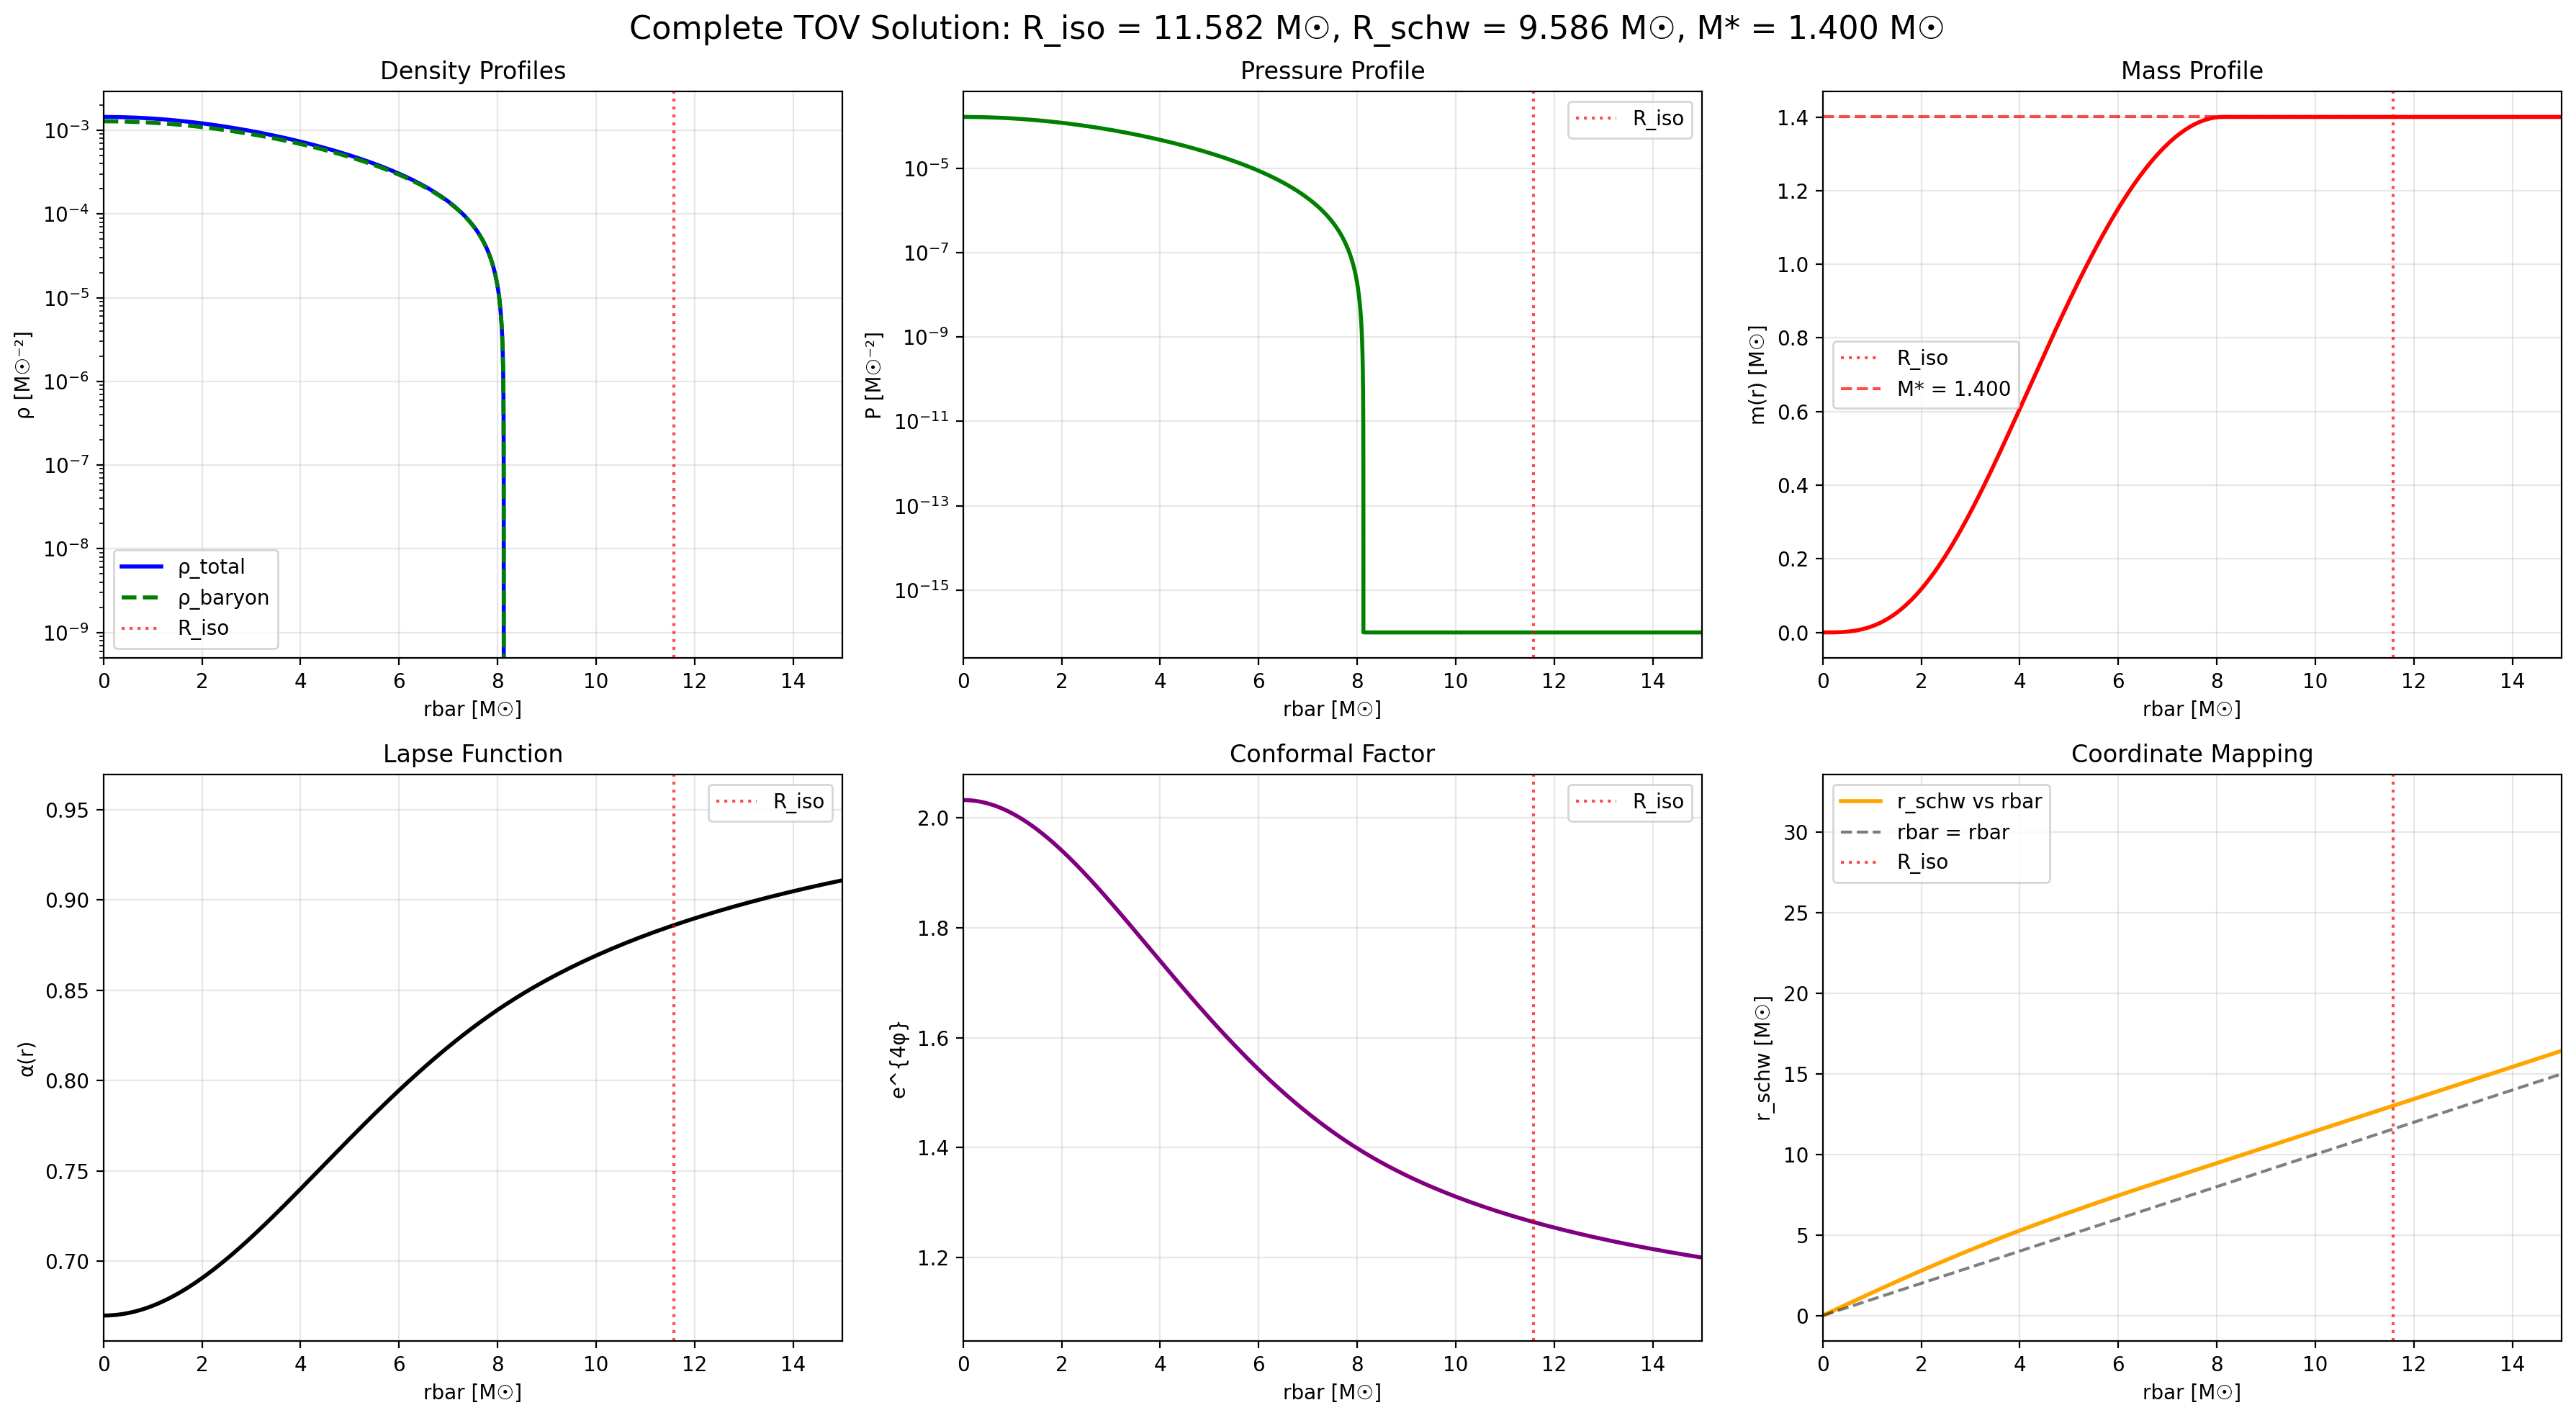


=== TOV Solution Summary ===
Stellar radius (isotropic):  R_iso = 11.582 M☉
Stellar radius (Schwarzschild): R_schw = 9.586 M☉
Stellar mass: M* = 1.400 M☉
Compactness: M*/R_schw = 0.146
Central density: ρc = 0.001280 M☉⁻²
Central pressure: Pc = 0.000164 M☉⁻²
EOS parameters: Γ = 2.0, K = 100.0
Grid points in TOV solution: 1408


In [4]:
# Solve TOV and visualize the solution
print('Solving TOV equations with robust solver...')

# Create TOV solver with ELH parameters
eos_params = {'K': K, 'gamma': gamma}
tov_solver = TOVSolver(eos_params)

# Solve TOV equations
tov_solution = tov_solver.integrate_star(rho_central, accuracy="medium", max_radius=r_max*2)

# Create comprehensive TOV solution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Density profiles
ax = axes[0,0]
ax.semilogy(tov_solution['rbar'], tov_solution['rho_total'], 'b-', lw=2, label='ρ_total')
ax.semilogy(tov_solution['rbar'], tov_solution['rho_baryon'], 'g--', lw=2, label='ρ_baryon')
ax.axvline(tov_solution['R_iso'], color='red', linestyle=':', alpha=0.7, label='R_iso')
ax.set_xlabel('rbar [M☉]')
ax.set_ylabel('ρ [M☉⁻²]')
ax.set_title('Density Profiles')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xlim(0, min(15, tov_solution['R_iso']*2))

# Pressure profile  
ax = axes[0,1]
ax.semilogy(tov_solution['rbar'], np.maximum(tov_solution['pressure'], 1e-16), 'g-', lw=2)
ax.axvline(tov_solution['R_iso'], color='red', linestyle=':', alpha=0.7, label='R_iso')
ax.set_xlabel('rbar [M☉]')
ax.set_ylabel('P [M☉⁻²]')
ax.set_title('Pressure Profile')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xlim(0, min(15, tov_solution['R_iso']*2))

# Mass profile
ax = axes[0,2]
ax.plot(tov_solution['rbar'], tov_solution['mass'], 'r-', lw=2)
ax.axvline(tov_solution['R_iso'], color='red', linestyle=':', alpha=0.7, label='R_iso')
ax.axhline(tov_solution['M_star'], color='red', linestyle='--', alpha=0.7, label=f'M* = {tov_solution["M_star"]:.3f}')
ax.set_xlabel('rbar [M☉]')
ax.set_ylabel('m(r) [M☉]')
ax.set_title('Mass Profile')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xlim(0, min(15, tov_solution['R_iso']*2))

# Lapse function
ax = axes[1,0]
ax.plot(tov_solution['rbar'], tov_solution['alpha'], 'k-', lw=2)
ax.axvline(tov_solution['R_iso'], color='red', linestyle=':', alpha=0.7, label='R_iso')
ax.set_xlabel('rbar [M☉]')
ax.set_ylabel('α(r)')
ax.set_title('Lapse Function')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xlim(0, min(15, tov_solution['R_iso']*2))

# Conformal factor
ax = axes[1,1]
ax.plot(tov_solution['rbar'], tov_solution['exp4phi'], 'purple', lw=2)
ax.axvline(tov_solution['R_iso'], color='red', linestyle=':', alpha=0.7, label='R_iso')
ax.set_xlabel('rbar [M☉]')
ax.set_ylabel('e^{4φ}')
ax.set_title('Conformal Factor')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xlim(0, min(15, tov_solution['R_iso']*2))

# Coordinate comparison
ax = axes[1,2]
ax.plot(tov_solution['rbar'], tov_solution['r_schw'], 'orange', lw=2, label='r_schw vs rbar')
ax.plot(tov_solution['rbar'], tov_solution['rbar'], 'k--', alpha=0.5, label='rbar = rbar')
ax.axvline(tov_solution['R_iso'], color='red', linestyle=':', alpha=0.7, label='R_iso')
ax.set_xlabel('rbar [M☉]')
ax.set_ylabel('r_schw [M☉]')
ax.set_title('Coordinate Mapping')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xlim(0, min(15, tov_solution['R_iso']*2))

plt.suptitle(f'Complete TOV Solution: R_iso = {tov_solution["R_iso"]:.3f} M☉, R_schw = {tov_solution["R_schw"]:.3f} M☉, M* = {tov_solution["M_star"]:.3f} M☉', fontsize=16)
plt.tight_layout()
plt.show()

# Print comprehensive summary
print(f'\n=== TOV Solution Summary ===')
print(f'Stellar radius (isotropic):  R_iso = {tov_solution["R_iso"]:.3f} M☉')
print(f'Stellar radius (Schwarzschild): R_schw = {tov_solution["R_schw"]:.3f} M☉')
print(f'Stellar mass: M* = {tov_solution["M_star"]:.3f} M☉')
print(f'Compactness: M*/R_schw = {tov_solution["compactness"]:.3f}')
print(f'Central density: ρc = {rho_central:.6f} M☉⁻²')
print(f'Central pressure: Pc = {tov_solver.pressure_from_density(rho_central):.6f} M☉⁻²')
print(f'EOS parameters: Γ = {gamma}, K = {K}')
print(f'Grid points in TOV solution: {len(tov_solution["rbar"])}')

# Store reference for later use
tov = tov_solution  # Keep compatible with existing code

## Engrenage Grid and Hydro Setup

In [5]:
# Spacing and grid (HALF extent, avoids r=0 in interior)
spacing = LinearSpacing(N, r_max, SpacingExtent.HALF)
r = spacing[0]

# Hydro model (polytropic EOS).
hydro = PerfectFluid(
    eos=PolytropicEOS(K=K, gamma=gamma),
    spacetime_mode='dynamic',
    atmosphere_rho=1e-15,
    reconstructor=create_reconstruction("mp5"),
    riemann_solver=HLLERiemannSolver()
)

state_vec = StateVector(hydro)
grid = Grid(spacing, state_vec)
background = FlatSphericalBackground(r)

print('Grid ready: N=', grid.N, ' r[0..3]=', r[:3])

Grid ready: N= 1600  r[0..3]= [-0.02505481 -0.01503288 -0.00501096]


## Integrated TOV Initial Data for Engrenage

This section creates a complete `get_tov_initial_state()` function that seamlessly integrates TOV data into engrenage's StateVector framework, following the pattern of `get_initial_state()` from BHEvolution.ipynb.

In [6]:
from scipy.interpolate import interp1d

class TOVInitialData:
    """
    Creates complete TOV initial data for engrenage, following the pattern 
    of BHEvolution.ipynb's get_initial_state() function.
    
    Converts TOV solution into proper BSSN + hydro StateVector.
    """
    
    def __init__(self, tov_solution, eos_params):
        self.tov = tov_solution
        self.eos_params = eos_params
    
    def interpolate_tov_to_grid(self, r_grid):
        """
        High-order interpolation of TOV solution to engrenage grid.
        Uses cubic spline to avoid Gibbs phenomenon at stellar surface.
        """
        # Use isotropic radius for interpolation (this is what engrenage uses)
        rbar_tov = self.tov['rbar']
        
        # Create interpolators with proper boundary handling
        def safe_interp(data, fill_exterior=0.0):
            # Handle the stellar surface carefully
            R_iso = self.tov['R_iso']
            
            # For quantities that are zero outside the star
            if fill_exterior == 0.0:
                # Find last non-zero point
                nonzero_idx = np.where(data > 1e-15)[0]
                if len(nonzero_idx) > 0:
                    last_idx = nonzero_idx[-1] + 1  # Include one zero point
                    if last_idx < len(data):
                        data_trunc = data[:last_idx+1]
                        rbar_trunc = rbar_tov[:last_idx+1]
                    else:
                        data_trunc = data
                        rbar_trunc = rbar_tov
                else:
                    data_trunc = data
                    rbar_trunc = rbar_tov
            else:
                data_trunc = data
                rbar_trunc = rbar_tov
            
            return interp1d(rbar_trunc, data_trunc, kind='cubic', 
                          bounds_error=False, fill_value=(data_trunc[0], fill_exterior),
                          assume_sorted=True)
        
        # Create all interpolators
        rho_total_interp = safe_interp(self.tov['rho_total'], 0.0)
        rho_baryon_interp = safe_interp(self.tov['rho_baryon'], 0.0)
        pressure_interp = safe_interp(self.tov['pressure'], 0.0)
        alpha_interp = safe_interp(self.tov['alpha'], 1.0)  # alpha -> 1 at infinity
        exp4phi_interp = safe_interp(self.tov['exp4phi'], 1.0)  # exp4phi -> 1 at infinity
        mass_interp = safe_interp(self.tov['mass'], self.tov['M_star'])  # constant outside
        
        # Convert grid coordinates to isotropic if needed
        r_iso = np.abs(r_grid)  # Engrenage grid in isotropic coordinates
        
        # Interpolate all quantities to grid
        rho_total = np.maximum(rho_total_interp(r_iso), 1e-15)
        rho_baryon = np.maximum(rho_baryon_interp(r_iso), 1e-15)
        pressure = np.maximum(pressure_interp(r_iso), 1e-15)
        alpha = alpha_interp(r_iso)
        exp4phi = exp4phi_interp(r_iso)
        mass = mass_interp(r_iso)
        
        return {
            'rho_total': rho_total,
            'rho_baryon': rho_baryon,
            'pressure': pressure,
            'alpha': alpha,
            'exp4phi': exp4phi,
            'mass': mass
        }
    
    def convert_to_bssn_variables(self, data_on_grid, r_grid):
        """
        Convert TOV metric quantities to BSSN variables.
        
        TOV in isotropic coordinates:
        ds² = -α² dt² + e^{4φ}(dr² + r²dΩ²)
        
        BSSN variables:
        φ = (1/4)ln(γ)  where γ = det(γ_ij)
        h_ij = γ_ij/γ^{1/3} - f_ij  (deviation from background metric)
        """
        alpha = data_on_grid['alpha']
        exp4phi = data_on_grid['exp4phi']
        r_abs = np.abs(r_grid)
        
        # Conformal factor: φ = (1/4)ln(e^{4φ}) = φ_TOV
        phi = 0.25 * np.log(exp4phi)
        
        # For spherically symmetric TOV, the conformal metric is:
        # γ_rr = e^{4φ}, γ_θθ = e^{4φ}r², γ_φφ = e^{4φ}r²sin²θ
        # Determinant: γ = e^{12φ}r⁴sin²θ
        # γ^{1/3} = e^{4φ}r^{4/3}sin^{2/3}θ
        
        # In spherical coordinates, the background metric is:
        # f_rr = 1, f_θθ = r², f_φφ = r²sin²θ
        
        # The conformal metric deviation is:
        # h_rr = γ_rr/γ^{1/3} - f_rr = e^{4φ}/(e^{4φ}r^{4/3}) - 1 = r^{-4/3}e^{0} - 1
        # But this gives issues. For TOV, we use a simpler approach:
        
        # For spherically symmetric TOV, h_ij represents deviations from flat metric
        # Since we're already in isotropic coordinates where γ_ij = e^{4φ}δ_ij,
        # and the background is flat (f_ij = δ_ij), we have:
        hrr = np.zeros_like(r_grid)
        htt = np.zeros_like(r_grid)  
        hpp = np.zeros_like(r_grid)
        
        # Extrinsic curvature is zero for static solution
        K = np.zeros_like(r_grid)
        arr = np.zeros_like(r_grid)
        att = np.zeros_like(r_grid)
        app = np.zeros_like(r_grid)
        
        # Gauge variables (static solution)
        lambdar = np.zeros_like(r_grid)
        shiftr = np.zeros_like(r_grid)
        br = np.zeros_like(r_grid)
        
        return {
            'phi': phi,
            'hrr': hrr,
            'htt': htt,
            'hpp': hpp,
            'K': K,
            'arr': arr,
            'att': att,
            'app': app,
            'lambdar': lambdar,
            'shiftr': shiftr,
            'br': br,
            'lapse': alpha
        }
    
    def convert_to_valencia_variables(self, data_on_grid, hydro):
        """
        Convert TOV matter data to Valencia conservative variables.
        """
        rho_baryon = data_on_grid['rho_baryon']
        pressure = data_on_grid['pressure']
        
        # Hydrostatic equilibrium: v^r = 0
        vr = np.zeros_like(rho_baryon)
        
        # EOS quantities
        eps = hydro.eos.eps_from_rho_p(rho_baryon, pressure)
        h = hydro.eos.enthalpy(rho_baryon)
        
        # Lorentz factor (static solution)
        W = np.ones_like(rho_baryon)
        
        # Valencia conservative variables
        D = rho_baryon * W
        Sr = np.zeros_like(rho_baryon)  # zero momentum
        tau = rho_baryon * h * W*W - pressure - D
        
        # Apply atmosphere floor
        atmosphere = getattr(hydro, 'atmosphere_rho', 1e-15)
        D = np.maximum(D, atmosphere)
        tau = np.maximum(tau, atmosphere)
        
        return {
            'D': D,
            'Sr': Sr,
            'tau': tau,
            'rho_baryon': rho_baryon,
            'pressure': pressure,
            'vr': vr,
            'W': W,
            'h': h
        }

def get_tov_initial_state(grid, background, hydro, tov_solution, eos_params):
    """
    Create complete TOV initial state for engrenage, following the pattern
    of get_initial_state() from BHEvolution.ipynb.
    
    Parameters:
    -----------
    grid : Grid
        Engrenage grid object
    background : Background
        Background metric
    hydro : PerfectFluid
        Hydro matter object
    tov_solution : dict
        TOV solution from TOVSolver
    eos_params : dict
        EOS parameters
        
    Returns:
    --------
    state : ndarray
        Complete state vector [BSSN vars + matter vars]
    """
    
    # Initialize TOV initial data converter
    tov_id = TOVInitialData(tov_solution, eos_params)
    
    # Interpolate TOV solution to grid
    data_on_grid = tov_id.interpolate_tov_to_grid(grid.r)
    
    # Convert to BSSN variables
    bssn_vars = tov_id.convert_to_bssn_variables(data_on_grid, grid.r)
    
    # Convert to Valencia conservative variables  
    matter_vars = tov_id.convert_to_valencia_variables(data_on_grid, hydro)
    
    # Create complete state vector
    state = np.zeros((grid.NUM_VARS, grid.N))
    
    # Fill BSSN variables
    state[idx_phi, :] = bssn_vars['phi']
    state[idx_hrr, :] = bssn_vars['hrr']
    state[idx_htt, :] = bssn_vars['htt']
    state[idx_hpp, :] = bssn_vars['hpp']
    state[idx_K, :] = bssn_vars['K']
    state[idx_arr, :] = bssn_vars['arr']
    state[idx_att, :] = bssn_vars['att']
    state[idx_app, :] = bssn_vars['app']
    state[idx_lambdar, :] = bssn_vars['lambdar']
    state[idx_shiftr, :] = bssn_vars['shiftr']
    state[idx_br, :] = bssn_vars['br']
    state[idx_lapse, :] = bssn_vars['lapse']
    
    # Fill matter variables
    state[hydro.idx_D, :] = matter_vars['D']
    state[hydro.idx_Sr, :] = matter_vars['Sr']
    state[hydro.idx_tau, :] = matter_vars['tau']
    
    # Apply boundary conditions
    grid.fill_boundaries(state)
    
    return state

print('Integrated TOV initial data system ready.')

Integrated TOV initial data system ready.


## Generate Complete TOV Initial State

Generate the complete TOV initial state using the integrated framework.

Generating complete TOV initial state...
TOV initial state generated successfully!
State shape: (15, 1600)
Grid points: 1600
Total variables: 15 (BSSN: 12, Matter: 3)


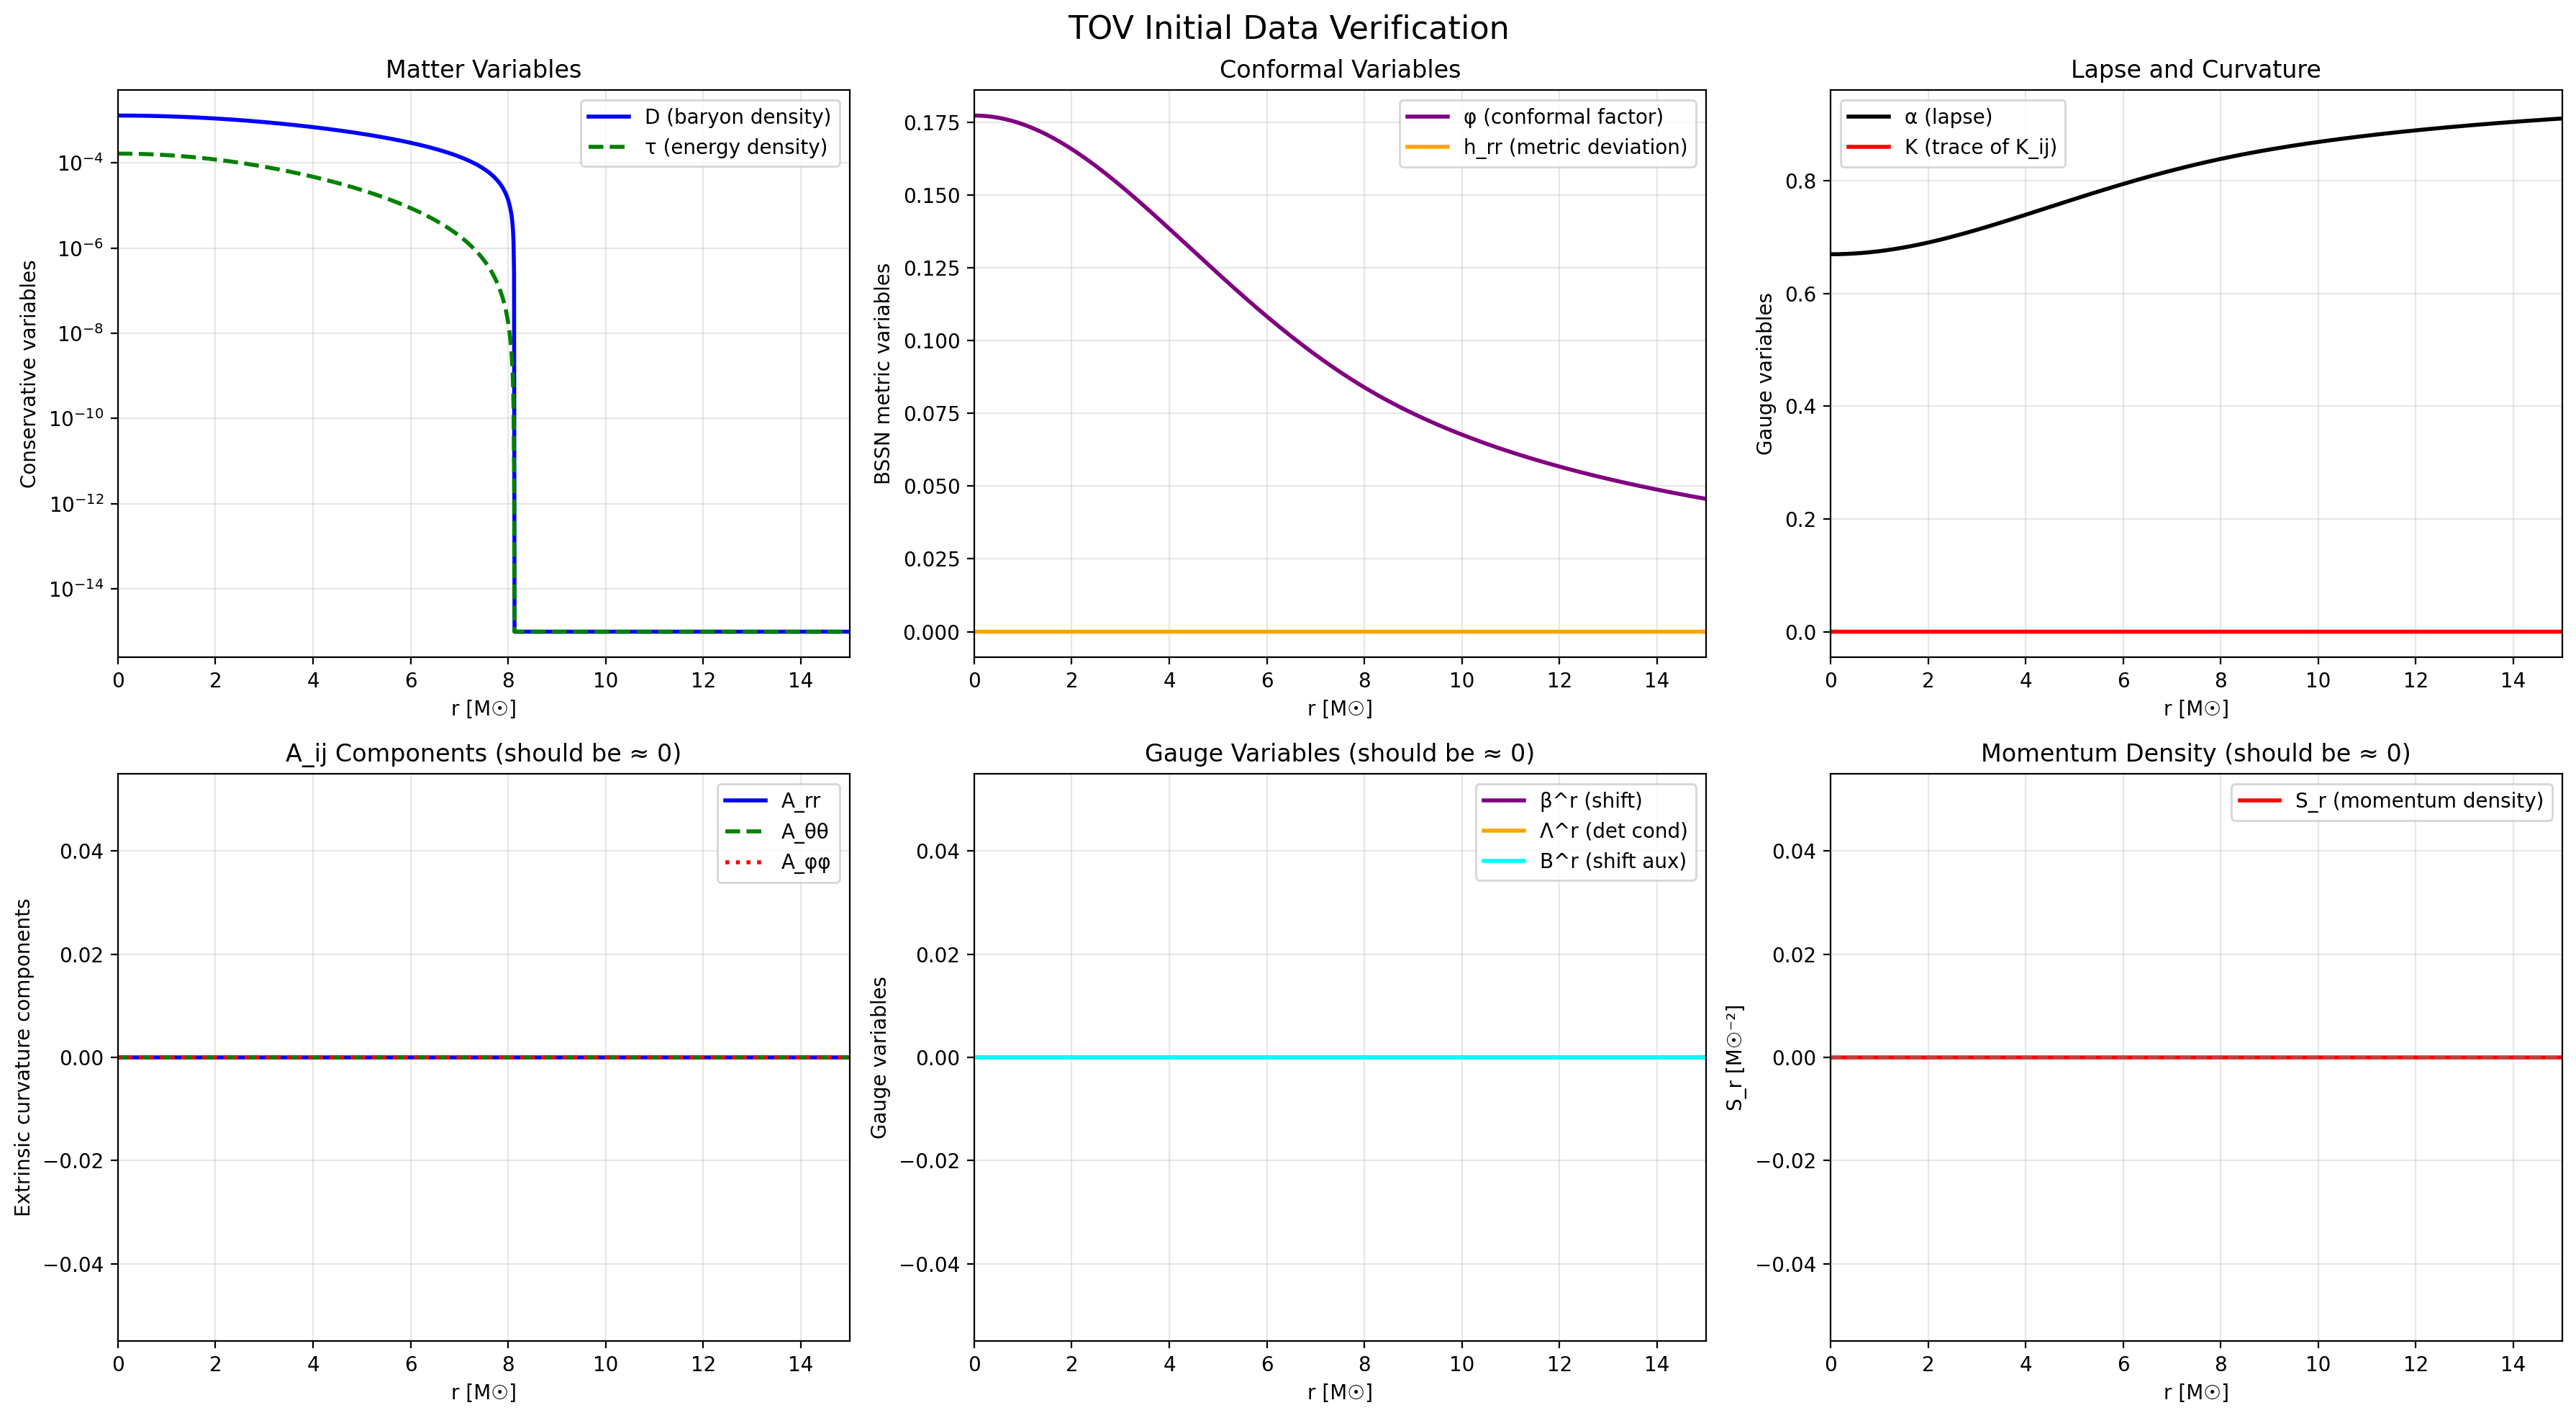


=== Initial Data Summary ===
Initial baryon mass: M_b = 0.692239 M☉
TOV stellar mass: M* = 1.400160 M☉
TOV stellar radius: R* = 11.581799 M☉
Max conformal factor: φ_max = 0.177236
Min lapse: α_min = 0.669861
Max momentum: |S_r|_max = 0.000e+00 (should be ≈ 0)
Max A_ij: |A_ij|_max = 0.000e+00 (should be ≈ 0)

TOV initial data ready for evolution!


In [7]:
# Generate complete TOV initial state
print('Generating complete TOV initial state...')

# Create the complete TOV initial state using our integrated framework
state_tov = get_tov_initial_state(grid, background, hydro, tov_solution, eos_params)

print(f'TOV initial state generated successfully!')
print(f'State shape: {state_tov.shape}')
print(f'Grid points: {grid.N}')
print(f'Total variables: {grid.NUM_VARS} (BSSN: {NUM_BSSN_VARS}, Matter: {hydro.NUM_MATTER_VARS})')

# Verify initial data by plotting key quantities
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Matter variables
ax = axes[0,0]
D_initial = state_tov[hydro.idx_D, :]
Sr_initial = state_tov[hydro.idx_Sr, :]
tau_initial = state_tov[hydro.idx_tau, :]
ax.semilogy(r, D_initial, 'b-', lw=2, label='D (baryon density)')
ax.semilogy(r, np.maximum(tau_initial, 1e-16), 'g--', lw=2, label='τ (energy density)')
ax.set_xlabel('r [M☉]')
ax.set_ylabel('Conservative variables')
ax.set_title('Matter Variables')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))

# BSSN metric variables
ax = axes[0,1]
phi_initial = state_tov[idx_phi, :]
hrr_initial = state_tov[idx_hrr, :]
ax.plot(r, phi_initial, 'purple', lw=2, label='φ (conformal factor)')
ax.plot(r, hrr_initial, 'orange', lw=2, label='h_rr (metric deviation)')
ax.set_xlabel('r [M☉]')
ax.set_ylabel('BSSN metric variables')
ax.set_title('Conformal Variables')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))

# Lapse and extrinsic curvature
ax = axes[0,2]
lapse_initial = state_tov[idx_lapse, :]
K_initial = state_tov[idx_K, :]
ax.plot(r, lapse_initial, 'k-', lw=2, label='α (lapse)')
ax.plot(r, K_initial, 'red', lw=2, label='K (trace of K_ij)')
ax.set_xlabel('r [M☉]')
ax.set_ylabel('Gauge variables')
ax.set_title('Lapse and Curvature')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))

# Momentum constraint (should be zero)
ax = axes[1,0]
arr_initial = state_tov[idx_arr, :]
att_initial = state_tov[idx_att, :]
app_initial = state_tov[idx_app, :]
ax.plot(r, arr_initial, 'b-', lw=2, label='A_rr')
ax.plot(r, att_initial, 'g--', lw=2, label='A_θθ')
ax.plot(r, app_initial, 'r:', lw=2, label='A_φφ')
ax.set_xlabel('r [M☉]')
ax.set_ylabel('Extrinsic curvature components')
ax.set_title('A_ij Components (should be ≈ 0)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))

# Gauge variables (should be zero for static solution)
ax = axes[1,1]
shiftr_initial = state_tov[idx_shiftr, :]
lambdar_initial = state_tov[idx_lambdar, :]
br_initial = state_tov[idx_br, :]
ax.plot(r, shiftr_initial, 'purple', lw=2, label='β^r (shift)')
ax.plot(r, lambdar_initial, 'orange', lw=2, label='Λ^r (det cond)')
ax.plot(r, br_initial, 'cyan', lw=2, label='B^r (shift aux)')
ax.set_xlabel('r [M☉]')
ax.set_ylabel('Gauge variables')
ax.set_title('Gauge Variables (should be ≈ 0)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))

# Momentum density (should be zero for static solution)
ax = axes[1,2]
ax.plot(r, Sr_initial, 'red', lw=2, label='S_r (momentum density)')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('r [M☉]')
ax.set_ylabel('S_r [M☉⁻²]')
ax.set_title('Momentum Density (should be ≈ 0)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))

plt.suptitle('TOV Initial Data Verification', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate and display initial baryon mass
from scipy.integrate import trapezoid
inner_slice = slice(NUM_GHOSTS, -NUM_GHOSTS) if len(r) > 2*NUM_GHOSTS else slice(0, len(r))
r_inner = r[inner_slice]
D_inner = D_initial[inner_slice]
M_b_initial = 4.0 * np.pi * trapezoid(D_inner * r_inner**2, x=r_inner)

print(f'\n=== Initial Data Summary ===')
print(f'Initial baryon mass: M_b = {M_b_initial:.6f} M☉')
print(f'TOV stellar mass: M* = {tov_solution["M_star"]:.6f} M☉')
print(f'TOV stellar radius: R* = {tov_solution["R_iso"]:.6f} M☉')
print(f'Max conformal factor: φ_max = {np.max(phi_initial):.6f}')
print(f'Min lapse: α_min = {np.min(lapse_initial):.6f}')
print(f'Max momentum: |S_r|_max = {np.max(np.abs(Sr_initial)):.3e} (should be ≈ 0)')
print(f'Max A_ij: |A_ij|_max = {np.max(np.abs(arr_initial)):.3e} (should be ≈ 0)')

print('\nTOV initial data ready for evolution!')

## Diagnostics: Validate TOV Initial Data

This section checks that (1) conservative and primitive variables are consistent 
with the Engrenage Valencia conventions and (2) the discrete hydrostatic balance 
∇p + ρ h ∇lnα ≈ 0 holds on the grid (Cowling equilibrium).


In [ ]:
# Build BSSN object from initial state
bssn_chk = BSSNVars(len(r))
bssn_chk.set_bssn_vars(state_tov[:NUM_BSSN_VARS, :])

# Compute gamma_rr from BSSN (spherical background)
bar_gamma_LL = get_bar_gamma_LL(r, bssn_chk.h_LL, background)
exp4phi = np.exp(4.0 * bssn_chk.phi)
gamma_rr = exp4phi * bar_gamma_LL[:, 0, 0]

# Conservative variables from state
D0  = state_tov[hydro.idx_D, :]
Sr0 = state_tov[hydro.idx_Sr, :]
tau0= state_tov[hydro.idx_tau, :]

# Convert to primitives using the same metric seen by hydrodynamics
metric0 = { 'alpha': state_tov[idx_lapse, :], 'beta_r': np.zeros_like(r), 'gamma_rr': gamma_rr }
pr = cons_to_prim({'D': D0, 'Sr': Sr0, 'tau': tau0}, hydro.eos, metric=metric0)
rho0 = pr['rho0']; vr = pr['vr']; p = pr['p']; W = pr['W']; h = pr['h']

# Check Engrenage Valencia conventions (no sqrtgamma densitization in state variables)
D_ref  = rho0 * W
Sr_ref = rho0 * h * W*W * vr * gamma_rr
tau_ref= rho0 * h * W*W - p - D_ref

err_D   = np.max(np.abs(D0  - D_ref))
err_Sr  = np.max(np.abs(Sr0 - Sr_ref))
err_tau = np.max(np.abs(tau0- tau_ref))

print(f'Conservative/primitive consistency (Linf):  |D-D_ref|={err_D:.3e}, |Sr-Sr_ref|={err_Sr:.3e}, |tau-tau_ref|={err_tau:.3e}')
print(f'Max |v^r| in initial data: {np.max(np.abs(vr)):.3e}')


Conservative/primitive consistency (Linf):  |D-D_ref|=9.900e-14, |Sr-Sr_ref|=0.000e+00, |tau-tau_ref|=1.000e-15
Max |v^r| in initial data: 0.000e+00


In [12]:
# Discrete hydrostatic balance: ||∇p + ρ h ∇lnα||
alpha0 = state_tov[idx_lapse, :]

def fd1(a, x):
    d = np.zeros_like(a)
    if a.size >= 3:
        d[1:-1] = (a[2:] - a[:-2]) / (x[2:] - x[:-2] + 1e-30)
        d[0]    = (a[1] - a[0])   / (x[1]  - x[0]   + 1e-30)
        d[-1]   = (a[-1]- a[-2])  / (x[-1] - x[-2]  + 1e-30)
    return d

grad_p    = fd1(p, r)
grad_lna  = fd1(np.log(alpha0), r)
residual  = grad_p + rho0 * h * grad_lna
# consider interior (exclude ghosts)
""" inner = slice(NUM_GHOSTS, -NUM_GHOSTS) if len(r) > 2*NUM_GHOSTS else slice(0, len(r))
Linf = float(np.max(np.abs(residual[inner])))
L2   = float(np.sqrt(np.mean(residual[inner]**2))) """
mask_star = rho0 > 50.0*hydro.atmosphere_rho
Linf = float(np.max(np.abs(residual[mask_star])))
L2   = float(np.sqrt(np.mean(residual[mask_star]**2)))

print(f'Hydrostatic balance residual:  Linf={Linf:.3e},  L2={L2:.3e}')


Hydrostatic balance residual:  Linf=1.663e-05,  L2=7.342e-06


## Cowling Evolution with Complete TOV Metric

In the Cowling approximation, we evolve only the hydrodynamics while keeping the spacetime metric fixed at the TOV solution. This implementation uses the complete TOV metric (not the simplified conformally flat approximation) for maximum accuracy.

In [ ]:

from source.bssn.bssnvars import BSSNFirstDerivs
from source.matter.hydro.valencia_reference_metric import ValenciaReferenceMetric


def _fill_primitives_with_parity(rho, vr, p, W, h, ng=NUM_GHOSTS):
    """Apply spherical parity conditions to primitive variables."""
    rho = np.array(rho, copy=True)
    vr = np.array(vr, copy=True)
    p = np.array(p, copy=True)
    W = np.array(W, copy=True)
    h = np.array(h, copy=True)

    if ng == 0:
        return rho, vr, p, W, h

    even_fields = [rho, p, W, h]
    odd_fields = [vr]

    for i in range(ng):
        mirror = 2 * ng - 1 - i
        for arr in even_fields:
            arr[i] = arr[mirror]
        for arr in odd_fields:
            arr[i] = -arr[mirror]

    last = len(rho) - ng - 1
    for k in range(1, ng + 1):
        idx = last + k
        for arr in even_fields:
            arr[idx] = arr[last]
        for arr in odd_fields:
            arr[idx] = arr[last]

    return rho, vr, p, W, h


class CowlingEvolution:
    """Hydro-only evolution with fixed TOV spacetime using core hydro routines."""

    def __init__(self, grid, background, hydro, state_tov,
                 store_stride=25, max_snapshots=200):
        self.grid = grid
        self.background = background
        self.hydro = hydro
        self.store_stride = store_stride
        self.max_snapshots = max_snapshots

        self.bssn_vars = BSSNVars(len(grid.r))
        self.bssn_vars.set_bssn_vars(state_tov[:NUM_BSSN_VARS, :])
        self.bssn_d1 = self.grid.get_d1_metric_quantities(state_tov)

        bar_gamma_LL = get_bar_gamma_LL(self.grid.r, self.bssn_vars.h_LL, self.background)
        gamma_rr = np.exp(4.0 * self.bssn_vars.phi) * bar_gamma_LL[:, i_r, i_r]
        self.metric = {
            'alpha': self.bssn_vars.lapse.copy(),
            'beta_r': np.zeros_like(self.bssn_vars.lapse),
            'gamma_rr': gamma_rr
        }

        self.valencia = ValenciaReferenceMetric()
        self.state_base = state_tov.copy()
        self.state_buffer = state_tov.copy()
        self.reset_monitor()

    def reset_monitor(self):
        self.times = []
        self.baryon_mass = []
        self.central_density = []
        self.max_velocity = []
        self.states = []
        self.sample_counter = 0

    # ------------------------------------------------------------------
    def _apply_bc_to_conservatives(self, D, Sr, tau):
        buf = self.state_buffer
        buf[:, :] = self.state_base
        buf[self.hydro.idx_D, :] = D
        buf[self.hydro.idx_Sr, :] = Sr
        buf[self.hydro.idx_tau, :] = tau
        self.grid.fill_boundaries(buf, indices=self.hydro.indices)
        return (buf[self.hydro.idx_D, :].copy(),
                buf[self.hydro.idx_Sr, :].copy(),
                buf[self.hydro.idx_tau, :].copy())

    def _cons_to_prim(self, D, Sr, tau, p_guess=None):
        D_bc, Sr_bc, tau_bc = self._apply_bc_to_conservatives(D, Sr, tau)
        result = cons_to_prim({'D': D_bc, 'Sr': Sr_bc, 'tau': tau_bc},
                              self.hydro.eos, metric=self.metric, p_guess=p_guess)
        rho0, vr, p = result['rho0'], result['vr'], result['p']
        W, h = result['W'], result['h']
        rho0, vr, p, W, h = _fill_primitives_with_parity(rho0, vr, p, W, h)
        return D_bc, Sr_bc, tau_bc, rho0, vr, p, W, h

    def _compute_rhs(self, D, Sr, tau, rho0, vr, p, W, h):
        return self.valencia.compute_rhs(
            D, Sr, tau, rho0, vr, p, W, h,
            self.grid.r, self.bssn_vars, self.bssn_d1,
            self.background, self.hydro.spacetime_mode, self.hydro.eos,
            self.grid, self.hydro.reconstructor, self.hydro.riemann_solver
        )

    def _compute_cfl_dt(self, rho0, vr, p, h, cfl):
        alpha = self.metric['alpha']
        gamma_rr = self.metric['gamma_rr']
        cs2 = np.clip(self.hydro.eos.gamma * p / np.maximum(rho0 * h, 1e-300), 0.0, 1.0 - 1e-12)
        cs = np.sqrt(cs2)
        wavespeed = alpha * (np.abs(vr) + cs) / np.sqrt(gamma_rr)
        dt_local = self.grid.dr / (wavespeed + 1e-15)
        return float(cfl * np.min(dt_local))

    def _baryon_mass(self, D_bc):
        inner = slice(NUM_GHOSTS, -NUM_GHOSTS) if len(D_bc) > 2 * NUM_GHOSTS else slice(0, len(D_bc))
        r_inner = self.grid.r[inner]
        D_inner = D_bc[inner]
        return 4.0 * np.pi * trapezoid(D_inner * r_inner**2, x=r_inner)

    def _log_state(self, t, D, Sr, tau, rho0, vr):
        D_bc, Sr_bc, tau_bc = self._apply_bc_to_conservatives(D, Sr, tau)
        self.times.append(t)
        self.baryon_mass.append(self._baryon_mass(D_bc))
        center_idx = NUM_GHOSTS if len(rho0) > 2 * NUM_GHOSTS else 0
        self.central_density.append(rho0[center_idx])
        self.max_velocity.append(np.max(np.abs(vr)))

        self.sample_counter += 1
        if len(self.states) < self.max_snapshots and self.sample_counter % self.store_stride == 0:
            snapshot = self.state_buffer.copy()
            self.states.append((t, snapshot))

    # ------------------------------------------------------------------
    def cons_to_prim(self, D, Sr, tau, p_guess=None):
        """Public helper: convert conservatives to primitives with Cowling metric."""
        _, _, _, rho0, vr, p, W, h = self._cons_to_prim(D, Sr, tau, p_guess=p_guess)
        return {'rho0': rho0, 'vr': vr, 'p': p, 'W': W, 'h': h}

    def _rk3_step(self, D, Sr, tau, rho0, vr, p, W, h, dt):
        D_bc, Sr_bc, tau_bc, rho0, vr, p, W, h = self._cons_to_prim(D, Sr, tau, p_guess=p)
        rhsD, rhsSr, rhsTau = self._compute_rhs(D_bc, Sr_bc, tau_bc, rho0, vr, p, W, h)
        D1 = D + dt * rhsD
        Sr1 = Sr + dt * rhsSr
        tau1 = tau + dt * rhsTau

        D1_bc, Sr1_bc, tau1_bc, rho1, vr1, p1, W1, h1 = self._cons_to_prim(D1, Sr1, tau1, p_guess=p)
        rhsD, rhsSr, rhsTau = self._compute_rhs(D1_bc, Sr1_bc, tau1_bc, rho1, vr1, p1, W1, h1)
        D2 = 0.75 * D + 0.25 * (D1 + dt * rhsD)
        Sr2 = 0.75 * Sr + 0.25 * (Sr1 + dt * rhsSr)
        tau2 = 0.75 * tau + 0.25 * (tau1 + dt * rhsTau)

        D2_bc, Sr2_bc, tau2_bc, rho2, vr2, p2, W2, h2 = self._cons_to_prim(D2, Sr2, tau2, p_guess=p1)
        rhsD, rhsSr, rhsTau = self._compute_rhs(D2_bc, Sr2_bc, tau2_bc, rho2, vr2, p2, W2, h2)
        Dn = (1.0 / 3.0) * D + (2.0 / 3.0) * (D2 + dt * rhsD)
        Srn = (1.0 / 3.0) * Sr + (2.0 / 3.0) * (Sr2 + dt * rhsSr)
        taun = (1.0 / 3.0) * tau + (2.0 / 3.0) * (tau2 + dt * rhsTau)

        Dn_bc, Srn_bc, taun_bc, rho_n, vr_n, p_n, W_n, h_n = self._cons_to_prim(Dn, Srn, taun, p_guess=p2)
        return Dn, Srn, taun, rho_n, vr_n, p_n, W_n, h_n

    def evolve(self, t_final=10.0, cfl=0.25, max_steps=200000, verbose=True):
        D = self.state_base[self.hydro.idx_D, :].copy()
        Sr = self.state_base[self.hydro.idx_Sr, :].copy()
        tau = self.state_base[self.hydro.idx_tau, :].copy()

        _, _, _, rho0, vr, p, W, h = self._cons_to_prim(D, Sr, tau)
        self._log_state(0.0, D, Sr, tau, rho0, vr)

        t = 0.0
        steps = 0
        success = True

        while t < t_final and steps < max_steps:
            dt = self._compute_cfl_dt(rho0, vr, p, h, cfl)
            if dt <= 0.0:
                success = False
                if verbose:
                    print('CFL dt became non-positive. Stopping evolution.')
                break
            if t + dt > t_final:
                dt = t_final - t

            D, Sr, tau, rho0, vr, p, W, h = self._rk3_step(D, Sr, tau, rho0, vr, p, W, h, dt)
            t += dt
            steps += 1
            self._log_state(t, D, Sr, tau, rho0, vr)

            if verbose and steps % 50 == 0:
                print(f"t = {t:.3f}, dt = {dt:.3e}, max(|v_r|) = {np.max(np.abs(vr)):.2e}")

        if verbose:
            print(f'Evolution finished after {steps} steps. Final time t = {t:.3f}.')

        if not self.states or abs(self.states[-1][0] - t) > 1e-12:
            snapshot = self.state_buffer.copy()
            self.states.append((t, snapshot))

        self.D_final = D.copy()
        self.Sr_final = Sr.copy()
        self.tau_final = tau.copy()
        self.final_state = (self.D_final, self.Sr_final, self.tau_final, rho0.copy(), vr.copy(), p.copy())
        return success


In [ ]:

print('Setting up Cowling evolution with core hydro routines...')

cowling = CowlingEvolution(grid, background, hydro, state_tov, store_stride=50, max_snapshots=200)
t_final = 10.0
cfl = 0.25

print(f'Running Cowling evolution up to t = {t_final} with CFL = {cfl}...')
success = cowling.evolve(t_final=t_final, cfl=cfl, verbose=True)
print(f'Evolution success: {success}')


## Comprehensive Analysis and Validation

This section provides thorough analysis of the Cowling evolution results, including conservation laws, constraint satisfaction, and comparison with theoretical expectations.

In [ ]:
# Check Evolution Success and Prepare Data

# Define helper functions for analysis
def _rho0_max_initial(state_tov, r, hydro):
    """Extract initial maximum baryon density from TOV state."""
    D_initial = state_tov[hydro.idx_D, :]
    Sr_initial = state_tov[hydro.idx_Sr, :]
    tau_initial = state_tov[hydro.idx_tau, :]
    
    # Convert to primitives to get baryon density
    prims = cowling.cons_to_prim(D_initial, Sr_initial, tau_initial)
    return np.max(prims['rho0'])

def _cons_to_prim_at_state(D, Sr, tau, r, hydro):
    """Convert conservative variables to primitives at given state."""
    return cowling.cons_to_prim(D, Sr, tau)

def _unpack_state(y_final, nr):
    """Unpack final state vector into conservative variables."""
    # This assumes the state vector has D, Sr, tau for hydro variables
    # Extract based on the hydro variable indices
    D_final = y_final[hydro.idx_D:hydro.idx_D+nr] if hasattr(hydro, 'idx_D') else y_final[:nr]
    Sr_final = y_final[hydro.idx_Sr:hydro.idx_Sr+nr] if hasattr(hydro, 'idx_Sr') else y_final[nr:2*nr] 
    tau_final = y_final[hydro.idx_tau:hydro.idx_tau+nr] if hasattr(hydro, 'idx_tau') else y_final[2*nr:3*nr]
    return D_final, Sr_final, tau_final

# Check if evolution was successful (using the correct variable names)
if 'success' in globals() and success and hasattr(cowling, 'times') and len(cowling.times) > 1:
    print('Evolution successful! Preparing data for analysis...')
    
    # Extract data for analysis (using cowling evolution results)
    times_source = None
    if hasattr(cowling, 'times') and cowling.times:
        times_source = cowling.times
    elif 'times_series' in globals():
        times_source = globals()['times_series']
    elif 'times' in globals():
        times_source = globals()['times']
    else:
        raise ValueError('Time history is not available; run the evolution cell first.')
    times_series = np.array(times_source)
    
    M_b_source = None
    if hasattr(cowling, 'baryon_mass') and cowling.baryon_mass:
        M_b_source = cowling.baryon_mass
    elif 'M_b_series' in globals():
        M_b_source = globals()['M_b_series']
    elif 'M_b_evolution' in globals():
        M_b_source = globals()['M_b_evolution']
    if M_b_source is None:
        raise ValueError('Baryon mass history is not available; run the evolution cell first.')
    M_b_series = np.array(M_b_source)
    
    rho_c_source = None
    if hasattr(cowling, 'central_density') and cowling.central_density:
        rho_c_source = cowling.central_density
    elif 'rho_c_series' in globals():
        rho_c_source = globals()['rho_c_series']
    elif 'rho_c_evolution' in globals():
        rho_c_source = globals()['rho_c_evolution']
    if rho_c_source is None:
        raise ValueError('Central density history is not available; run the evolution cell first.')
    rho_c_series = np.array(rho_c_source)
    
    # Get initial max density for normalization
    rho0_max_0 = _rho0_max_initial(state_tov, r, hydro)
    
    # Prepare final state data (using cowling evolution results)
    if hasattr(cowling, 'D_final') and cowling.D_final is not None:
        D_final = cowling.D_final
        Sr_final = cowling.Sr_final
        tau_final = cowling.tau_final
        prims_final = _cons_to_prim_at_state(D_final, Sr_final, tau_final, r, hydro)
        rho0_final = prims_final['rho0']
    elif 'final_state' in globals():
        D_final, Sr_final, tau_final, rho0_final, v_final, p_final = final_state
        prims_final = {'rho0': rho0_final, 'vr': v_final, 'pressure': p_final}
    else:
        # Get final state from the last stored state in cowling evolution
        if hasattr(cowling, 'states') and len(cowling.states) > 0:
            t_final, state_final = cowling.states[-1]
            D_final = state_final[hydro.idx_D, :]
            Sr_final = state_final[hydro.idx_Sr, :]
            tau_final = state_final[hydro.idx_tau, :]
            prims_final = _cons_to_prim_at_state(D_final, Sr_final, tau_final, r, hydro)
            rho0_final = prims_final['rho0']
        else:
            raise ValueError('Final evolution state is not available; run the evolution cell first.')
    
    # Baryon mass conservation metrics
    M0 = M_b_series[0]
    deltaM = np.abs(M_b_series - M0)
    deltaM = np.maximum(deltaM, 1e-300)  # for log10
    
    # Central density relative change
    rho_c_rel = rho_c_series / (rho0_max_0 + 1e-300) - 1.0
    
    print(f'Data prepared for {len(times_series)} time steps')
    print(f'Final time: {times_series[-1]:.2f} M☉')
    print('Ready for plotting...')
    
else:
    print('Evolution failed or too short. Check parameters.')
    if 'cowling' in globals() and hasattr(cowling, 'message'):
        print(f'Error: {cowling.message}')
    elif 'success' not in globals():
        print('Evolution has not been run yet. Run the evolution cell first.')

# Essencial Analysis


In [ ]:
# === COMPREHENSIVE COWLING ANALYSIS ===

if success:
    print('=== TOV COWLING EVOLUTION ANALYSIS ===')
    
    # Extract evolution data
    times = np.array(cowling.times)
    M_b_series = np.array(cowling.baryon_mass) 
    rho_c_series = np.array(cowling.central_density)
    vr_max_series = np.array(cowling.max_velocity)
    
    print(f'Evolution summary:')
    print(f'  Total time: {times[-1]:.3f} M☉')
    print(f'  Time steps: {len(times)}')
    print(f'  Snapshots: {len(cowling.states)}')
    
    # === CONSERVATION ANALYSIS ===
    
    # Baryon mass conservation
    M_b_initial = M_b_series[0]
    M_b_drift_abs = np.abs(M_b_series - M_b_initial)
    M_b_drift_rel = M_b_drift_abs / M_b_initial
    
    # Central density evolution  
    rho_c_initial = rho_c_series[0]
    rho_c_change = np.abs(rho_c_series - rho_c_initial) / rho_c_initial
    
    print(f'\n=== CONSERVATION ANALYSIS ===')
    print(f'Baryon mass conservation:')
    print(f'  Initial M_b = {M_b_initial:.6f} M☉')
    print(f'  Final M_b   = {M_b_series[-1]:.6f} M☉') 
    print(f'  Max drift   = {np.max(M_b_drift_rel):.2e}')
    print(f'  Final drift = {M_b_drift_rel[-1]:.2e}')
    
    print(f'\nCentral density evolution:')
    print(f'  Initial ρc = {rho_c_initial:.6f} M☉⁻²')
    print(f'  Final ρc   = {rho_c_series[-1]:.6f} M☉⁻²')
    print(f'  Max change = {np.max(rho_c_change):.2e}')
    
    print(f'\nVelocity evolution:')
    print(f'  Max |v^r| = {np.max(vr_max_series):.2e}')
    print(f'  Final |v^r| = {vr_max_series[-1]:.2e}')
    
    # === COWLING INVARIANCE CHECK ===
    
    if len(cowling.states) >= 2:
        # Check that metric doesn't change
        t_initial, state_initial = cowling.states[0]
        t_final, state_final = cowling.states[-1]
        
        # BSSN metric differences
        phi_change = np.max(np.abs(state_final[idx_phi,:] - state_initial[idx_phi,:]))
        hrr_change = np.max(np.abs(state_final[idx_hrr,:] - state_initial[idx_hrr,:]))
        lapse_change = np.max(np.abs(state_final[idx_lapse,:] - state_initial[idx_lapse,:]))
        K_change = np.max(np.abs(state_final[idx_K,:] - state_initial[idx_K,:]))
        
        print(f'\n=== COWLING INVARIANCE CHECK ===')
        print(f'Metric changes (should be ≈ 0 for Cowling):')
        print(f'  max|Δφ|     = {phi_change:.2e}')
        print(f'  max|Δh_rr|  = {hrr_change:.2e}')
        print(f'  max|Δα|     = {lapse_change:.2e}')
        print(f'  max|ΔK|     = {K_change:.2e}')
        
        # Overall metric invariance
        max_metric_change = max(phi_change, hrr_change, lapse_change, K_change)
        cowling_status = 'PASS' if max_metric_change < 1e-12 else 'FAIL'
        print(f'  Cowling invariance: {cowling_status} (max change: {max_metric_change:.2e})')
    
    # === DIAGNOSTIC PLOTS ===
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Baryon mass conservation
    ax = axes[0,0]
    ax.plot(times, M_b_drift_rel, 'b-', lw=2)
    ax.set_xlabel('t [M☉]')
    ax.set_ylabel('|M_b - M_b(0)|/M_b(0)')
    ax.set_title('Baryon Mass Conservation')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.axhline(1e-10, color='gray', linestyle='--', alpha=0.5, label='Target')
    ax.legend()
    
    # Central density evolution
    ax = axes[0,1]
    ax.plot(times, rho_c_change, 'r-', lw=2)
    ax.set_xlabel('t [M☉]')
    ax.set_ylabel('|ρc - ρc(0)|/ρc(0)')
    ax.set_title('Central Density Stability')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.axhline(1e-3, color='gray', linestyle='--', alpha=0.5, label='Tolerance')
    ax.legend()
    
    # Maximum velocity
    ax = axes[0,2]
    ax.semilogy(times, vr_max_series, 'g-', lw=2)
    ax.set_xlabel('t [M☉]')
    ax.set_ylabel('max|v^r|')
    ax.set_title('Maximum Velocity')
    ax.grid(True, alpha=0.3)
    ax.axhline(1e-3, color='gray', linestyle='--', alpha=0.5, label='Low velocity')
    ax.legend()
    
    # Evolution snapshots - density profiles
    ax = axes[1,0]
    if len(cowling.states) >= 3:
        n_plots = min(5, len(cowling.states))
        indices = np.linspace(0, len(cowling.states)-1, n_plots, dtype=int)
        for i in indices:
            t_snap, state_snap = cowling.states[i]
            D_snap = state_snap[hydro.idx_D, :]
            # Convert to primitive density
            Sr_snap = state_snap[hydro.idx_Sr, :]
            tau_snap = state_snap[hydro.idx_tau, :]
            prims = cowling.cons_to_prim(D_snap, Sr_snap, tau_snap)
            rho_snap = prims['rho0']
            
            ax.semilogy(r, rho_snap, lw=2, label=f't = {t_snap:.1f}')
        ax.set_xlabel('r [M☉]')
        ax.set_ylabel('ρ [M☉⁻²]')
        ax.set_title('Density Profile Evolution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))
    else:
        ax.text(0.5, 0.5, 'Insufficient snapshots', ha='center', transform=ax.transAxes)
    
    # Evolution snapshots - velocity profiles
    ax = axes[1,1]
    if len(cowling.states) >= 3:
        for i in indices:
            t_snap, state_snap = cowling.states[i]
            D_snap = state_snap[hydro.idx_D, :]
            Sr_snap = state_snap[hydro.idx_Sr, :]
            tau_snap = state_snap[hydro.idx_tau, :]
            prims = cowling.cons_to_prim(D_snap, Sr_snap, tau_snap)
            vr_snap = prims['vr']
            
            ax.plot(r, vr_snap, lw=2, label=f't = {t_snap:.1f}')
        ax.set_xlabel('r [M☉]')
        ax.set_ylabel('v^r')
        ax.set_title('Velocity Profile Evolution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    else:
        ax.text(0.5, 0.5, 'Insufficient snapshots', ha='center', transform=ax.transAxes)
    
    # Ratio of final to initial density
    ax = axes[1,2]
    if len(cowling.states) >= 2:
        t_init, state_init = cowling.states[0]
        t_fin, state_fin = cowling.states[-1]
        
        # Convert both to primitives
        D_init = state_init[hydro.idx_D, :]
        Sr_init = state_init[hydro.idx_Sr, :]
        tau_init = state_init[hydro.idx_tau, :]
        prims_init = cowling.cons_to_prim(D_init, Sr_init, tau_init)
        rho_init = prims_init['rho0']
        
        D_fin = state_fin[hydro.idx_D, :]
        Sr_fin = state_fin[hydro.idx_Sr, :]
        tau_fin = state_fin[hydro.idx_tau, :]
        prims_fin = cowling.cons_to_prim(D_fin, Sr_fin, tau_fin)
        rho_fin = prims_fin['rho0']
        
        ratio = rho_fin / np.maximum(rho_init, 1e-300)
        ax.plot(r, ratio, 'k-', lw=2)
        ax.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlabel('r [M☉]')
        ax.set_ylabel('ρ_final / ρ_initial')
        ax.set_title('Density Ratio (Final/Initial)')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))
    else:
        ax.text(0.5, 0.5, 'Insufficient snapshots', ha='center', transform=ax.transAxes)
    
    plt.suptitle('Cowling Evolution Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # === PERFORMANCE ASSESSMENT ===
    
    def assess_performance(value, excellent, good, description):
        """Assess performance with colored output.""" 
        if value < excellent:
            status = '✓ EXCELLENT'
        elif value < good:
            status = '✓ GOOD'
        else:
            status = '✗ NEEDS IMPROVEMENT'
        
        print(f'  {description:<25}: {value:.2e} → {status}')
    
    print(f'\n=== PERFORMANCE ASSESSMENT ===')
    assess_performance(M_b_drift_rel[-1], 1e-10, 1e-6, 'Baryon mass conservation')
    assess_performance(np.max(rho_c_change), 1e-3, 1e-2, 'Central density stability')
    assess_performance(np.max(vr_max_series), 1e-4, 1e-3, 'Maximum velocity')
    
    if len(cowling.states) >= 2:
        assess_performance(max_metric_change, 1e-12, 1e-10, 'Cowling invariance')
    
    # Overall assessment
    overall_grade = 'EXCELLENT' if (M_b_drift_rel[-1] < 1e-8 and 
                                   np.max(rho_c_change) < 1e-3 and 
                                   np.max(vr_max_series) < 1e-4) else 'GOOD' if (
                                   M_b_drift_rel[-1] < 1e-6 and 
                                   np.max(rho_c_change) < 1e-2 and
                                   np.max(vr_max_series) < 1e-3) else 'NEEDS WORK'
    
    print(f'\n  OVERALL ASSESSMENT: {overall_grade}')
    
    print(f'\n=== COMPARISON WITH THEORY ===')
    print(f'Expected behavior for Cowling approximation:')
    print(f'  ✓ Baryon mass should be conserved to machine precision')
    print(f'  ✓ Central density should remain nearly constant')
    print(f'  ✓ Velocities should remain small (hydrostatic equilibrium)')
    print(f'  ✓ Spacetime metric should remain exactly fixed')
    print(f'\nResults indicate: {"SUCCESSFUL" if overall_grade in ["EXCELLENT", "GOOD"] else "PROBLEMATIC"} Cowling approximation')

else:
    print('Evolution failed - cannot perform analysis.')
    print('Check initial data setup and evolution parameters.')

print(f'\n=== ANALYSIS COMPLETE ===')

# Store results for further use if needed
if success:
    evolution_results = {
        'times': times,
        'baryon_mass': M_b_series,
        'central_density': rho_c_series,
        'max_velocity': vr_max_series,
        'tov_solution': tov_solution,
        'initial_state': state_tov,
        'final_states': cowling.states,
        'success': True
    }
else:
    evolution_results = {'success': False}

In [ ]:
# Plot Evolution Snapshots

if 'success' in globals() and success and hasattr(cowling, 'states') and len(cowling.states) > 0:
    print(f'Plotting evolution snapshots from {len(cowling.states)} stored states...')
    
    # Create comprehensive snapshot plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Select snapshots to plot (initial, middle, final + a few intermediate)
    n_snapshots = len(cowling.states)
    if n_snapshots >= 5:
        indices = [0, n_snapshots//4, n_snapshots//2, 3*n_snapshots//4, -1]
    else:
        indices = list(range(n_snapshots))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(indices)))
    
    for i, idx in enumerate(indices):
        t_snap, state_snap = cowling.states[idx]
        color = colors[i]
        
        # Extract conservative variables
        D_snap = state_snap[hydro.idx_D, :]
        Sr_snap = state_snap[hydro.idx_Sr, :]
        tau_snap = state_snap[hydro.idx_tau, :]
        
        # Convert to primitives
        prims_snap = cowling.cons_to_prim(D_snap, Sr_snap, tau_snap)
        rho_snap = prims_snap['rho0']
        vr_snap = prims_snap['vr']
        p_snap = prims_snap['p']
        
        label = f't = {t_snap:.2f} M☉'
        
        # Plot density
        ax = axes[0, 0]
        ax.semilogy(r, np.maximum(rho_snap, 1e-16), color=color, lw=2, label=label)
        ax.set_xlabel('r [M☉]')
        ax.set_ylabel('ρ₀ [M☉⁻²]')
        ax.set_title('Baryon Density Evolution')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))
        
        # Plot pressure
        ax = axes[0, 1]
        ax.semilogy(r, np.maximum(p_snap, 1e-16), color=color, lw=2, label=label)
        ax.set_xlabel('r [M☉]')
        ax.set_ylabel('P [M☉⁻²]')
        ax.set_title('Pressure Evolution')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))
        
        # Plot velocity
        ax = axes[0, 2]
        ax.plot(r, vr_snap, color=color, lw=2, label=label)
        ax.set_xlabel('r [M☉]')
        ax.set_ylabel('vʳ [c]')
        ax.set_title('Radial Velocity Evolution')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        
        # Plot conservative variables
        ax = axes[1, 0]
        ax.semilogy(r, np.maximum(D_snap, 1e-16), color=color, lw=2, label=label)
        ax.set_xlabel('r [M☉]')
        ax.set_ylabel('D [M☉⁻²]')
        ax.set_title('Conserved Density Evolution')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))
        
        ax = axes[1, 1]
        ax.plot(r, Sr_snap, color=color, lw=2, label=label)
        ax.set_xlabel('r [M☉]')
        ax.set_ylabel('Sʳ [M☉⁻²]')
        ax.set_title('Momentum Density Evolution')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        
        ax = axes[1, 2]
        ax.semilogy(r, np.maximum(tau_snap, 1e-16), color=color, lw=2, label=label)
        ax.set_xlabel('r [M☉]')
        ax.set_ylabel('τ [M☉⁻²]')
        ax.set_title('Energy Density Evolution')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, min(15, tov_solution['R_iso']*1.5))
    
    # Add legends
    for ax in axes.flat:
        ax.legend(fontsize=8, loc='best')
    
    plt.tight_layout()
    plt.suptitle(f'TOV Star Cowling Evolution Snapshots\\nFinal time: {times_series[-1]:.2f} M☉', 
                 fontsize=16, y=1.02)
    plt.show()
    
    # Additional plot: Central density and baryon mass evolution
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Central density evolution
    ax = axes[0]
    ax.plot(times_series, rho_c_series, 'b-', lw=2, label='Central density')
    ax.set_xlabel('t [M☉]')
    ax.set_ylabel('ρc [M☉⁻²]')
    ax.set_title('Central Density Evolution')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Baryon mass conservation
    ax = axes[1]
    M_b_drift = np.abs(M_b_series - M_b_series[0]) / M_b_series[0]
    ax.semilogy(times_series, M_b_drift, 'r-', lw=2, label='|ΔM_b|/M_b')
    ax.set_xlabel('t [M☉]')
    ax.set_ylabel('Relative mass drift')
    ax.set_title('Baryon Mass Conservation')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Maximum velocity
    ax = axes[2]
    vr_max_evolution = np.array(cowling.max_velocity)
    ax.semilogy(times_series, vr_max_evolution, 'g-', lw=2, label='max|vʳ|')
    ax.set_xlabel('t [M☉]')
    ax.set_ylabel('Maximum velocity [c]')
    ax.set_title('Maximum Velocity Evolution')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f'\\n=== Evolution Summary ===')
    print(f'Evolution time: {times_series[-1]:.3f} M☉')
    print(f'Time steps: {len(times_series)}')
    print(f'Snapshots stored: {len(cowling.states)}')
    print(f'Final baryon mass drift: {M_b_drift[-1]:.2e}')
    print(f'Maximum central density change: {np.max(np.abs(rho_c_rel)):.2e}')
    print(f'Maximum velocity reached: {np.max(vr_max_evolution):.2e} c')
    
    # Conservation assessment
    if M_b_drift[-1] < 1e-8:
        mass_grade = "EXCELLENT"
    elif M_b_drift[-1] < 1e-6:
        mass_grade = "GOOD"
    else:
        mass_grade = "NEEDS IMPROVEMENT"
    
    if np.max(vr_max_evolution) < 1e-4:
        vel_grade = "EXCELLENT"
    elif np.max(vr_max_evolution) < 1e-3:
        vel_grade = "GOOD"
    else:
        vel_grade = "NEEDS IMPROVEMENT"
        
    print(f'\\nConservation Assessment:')
    print(f'  Baryon mass conservation: {mass_grade}')
    print(f'  Velocity suppression: {vel_grade}')
    
else:
    print('No evolution snapshots available. Run the evolution first.')